<a href="https://colab.research.google.com/github/Kaan-wq/ml_tokamak/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
import tensorflow as tf

!pip install tensorflow_addons
!pip install keras-tuner -q

import keras
import keras_tuner as kt
from kerastuner import RandomSearch
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

ModuleNotFoundError: No module named 'tensorflow'

#**I - Preprocessing of the data**

Below is the preprocessing pipeline of the data. \\
Essentially, we feature engineer a few columns, normalize the data and finally, we split it into a training and testing set.

In [ ]:
# load dataset using pickle
import pickle
with open("../data/dataset_disruption_characterization.pickle", "rb") as f:
    dataset = pickle.load(f)

Here we load the data from the drive and put it into a more practical **data structure**. \\
We add a column <code>['IPE']</code> which represents the current difference between the reference and actual currents.

In [ ]:
df_data = []

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']
    metadata = entry['metadata']
    event = metadata['time_event']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])
    df['Time'] = d['time']

    if event:
      #Find closest points to time_event
      differences = np.abs(df['Time'] - event)
      closest_indices = np.argsort(differences)[:15]

      #Assign labels to closest points
      df['Close'] = 0
      df.loc[closest_indices, 'Close'] = 1
    else:
      df['Close'] = 0

    contains_nan = df.isna().any().any()

    if not contains_nan:
      df_data.append([df.values, label])

print("One point in the time series :")
print(df_data[1][0][19])

One point in the time series :
[ 1.95124825e+06  1.99950000e+06  1.95838574e+03  2.76184231e-02
  1.24208093e+00  4.13856077e+00  3.51704687e-01 -3.66213632e+00
  4.82517500e+04  9.08199978e+00  0.00000000e+00]


We **normalize and split** into training and test sets before feeding it into our **Neural Network**.

In [ ]:
# Normalized data
df_norm = []

# Initialize a scaler
scaler = StandardScaler()

for series, label in df_data:
    # Apply normalization to each time series
    series_normalized = scaler.fit_transform(series[:, :])

    # Append the normalized series and the label
    df_norm.append([series_normalized, label])

print("One point in the normalized time series :")
print(df_norm[1][0][19])

One point in the normalized time series :
[ 0.01234431  0.         -0.50029967 -0.48162395 -1.73205081 -1.73205081
 -1.73205081 -2.89745484 -0.01234431  1.64745696  0.        ]


In [ ]:
# Separate the features and labels
features, labels = zip(*df_norm)

# Convert to numpy
features = np.array(features)
labels = np.array(labels)

# One-hot encode the labels
labels = to_categorical(labels, num_classes=3)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

#**II - Model tuning**

Here we use the hyperparamter tuner from keras to find the best model architecture.

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    model.add(keras.Input(shape=(X_train[0].shape)))

    # LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        # For the last LSTM layer, set return_sequences=False
        if i == hp.Int('num_lstm_layers', 1, 3) - 1:
            model.add(keras.layers.LSTM(units=hp.Int('lstm_units_' + str(i), min_value=32, max_value=512, step=32), return_sequences=False))
        else:
            model.add(keras.layers.LSTM(units=hp.Int('lstm_units_' + str(i), min_value=32, max_value=512, step=32), return_sequences=True))

    # Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int('dense_units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))

    model.add(keras.layers.Dense(3, activation='softmax'))  # Output layer

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=3, average=None)]
                  )

    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # number of model configurations to try
    executions_per_trial=1,  # number of models that should be built and fit for each trial
    directory='my_dir0',
    project_name='helloworld')


tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 24s]
val_loss: 0.10173686593770981

Best val_loss So Far: 0.09573870897293091
Total elapsed time: 00h 14m 29s


In [ ]:
# Get the best models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

best_model.build(input_shape=X_train.shape)

# Architecture of the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 448)               824320    
                                                                 
 dense (Dense)               (None, 384)               172416    
                                                                 
 dense_1 (Dense)             (None, 3)                 1155      
                                                                 
Total params: 997891 (3.81 MB)
Trainable params: 997891 (3.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Evaluate the model on the test set
scores = best_model.evaluate(X_test, y_test)
f1_scores = scores[2:]
print(f"F1 Scores for test set: {f1_scores}")

6/6 [==============================] - 1s 7ms/step - loss: 0.0957 - accuracy: 0.9611 - f1_score: 0.8477
F1 Scores for test set: [array([1.        , 0.9113924 , 0.63157904], dtype=float32)]


Epoch 1/100
23/23 [==============================] - 2s 11ms/step - loss: 0.0410 - accuracy: 0.9847 - f1_score: 0.9427 - val_loss: 0.1113 - val_accuracy: 0.9556 - val_f1_score: 0.8325
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0379 - accuracy: 0.9889 - f1_score: 0.9587 - val_loss: 0.1091 - val_accuracy: 0.9556 - val_f1_score: 0.8325
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0359 - accuracy: 0.9847 - f1_score: 0.9416 - val_loss: 0.1024 - val_accuracy: 0.9611 - val_f1_score: 0.8477
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0345 - accuracy: 0.9889 - f1_score: 0.9579 - val_loss: 0.1260 - val_accuracy: 0.9556 - val_f1_score: 0.8325
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0329 - accuracy: 0.9861 - f1_score: 0.9494 - val_loss: 0.1054 - val_accuracy: 0.9667 - val_f1_score: 0.8639
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0339 - ac

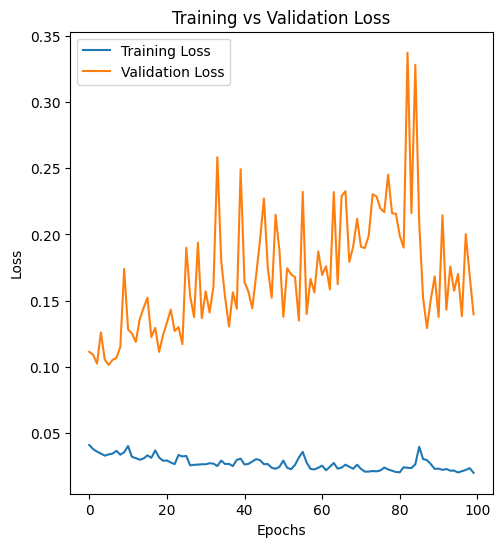

In [ ]:
# Train the model
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
print(f"Evaluation of the model: ")
scores = best_model.evaluate(X_test, y_test)

# Access the F1 score for each category
f1_scores = scores[2:]  # Assuming they are the third metric onwards
print(f"F1 Scores for each category: {f1_scores}")

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()